In [3]:
import glob
import gzip
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import mysql.connector

plt.rcParams['font.family'] = 'NanumGothic'
pd.set_option('display.max.colwidth', 1000)


pattern = r"\[(.*?)\] \[(.*?)\]: (.*)"
file_list = glob.glob('log/*.gz')
data = []
for file in file_list:
    with gzip.open(file, 'rb') as f:
        log_data = f.read().decode('utf-8')
        groups = re.findall(pattern, log_data)
        for group in groups:
            data.append(group)


db = #db정보
cursor = db.cursor()
query = 'SELECT name FROM player_info_view'
cursor.execute(query)
rows = cursor.fetchall()
user_df = pd.DataFrame(rows, columns=['Username'])
lst = list(user_df['Username'].values)

def user_logit(df,lst):
    extracted = []
    for message in df['Message']:
        for ltem in lst:
            if ltem in message:
                extracted.append(ltem)
                break
        else:
            extracted.append(' ')
    df['user'] = extracted 

# 기본 전처리 
df = pd.DataFrame(data, columns=['Timestamp', 'Level', 'Message'])
df = df[~df['Message'].str.contains('청소')] 

# 접속 관련
d_login = df[(df['Message'].str.contains('\[\+\].*')) | (df['Message'].str.contains('\[\-\].*'))]  
d_login = d_login[~d_login['Message'].str.contains('님이')]

# 구입 관련
df_buy = df[df['Message'].str.contains('구입')].copy()
df_buy = df_buy[~df_buy['Message'].str.contains('챗')] # 채팅에서 구매라는 단어 언급 하는거 제외
df_buy['Item'] = df_buy['Message'].str.extract(r'님이 ([^(]+)') # 님이 이후에 괄호를 뺀 모든 문자열(아이템이 뭔지)
df_buy['Count'] = df_buy['Message'].str.extract(r'(\d+) 만큼') # 숫자 (몇개샀는지?)
df_buy['cost'] = df_buy['Message'].str.extract(r'(\d+)를') # (비용이 얼마나 들었는지?)
df_buy["category"] = df_buy["Message"].str.findall(r"\((.+?)\.") # (카테고리는 뭘르 가장 많이 샀는지)
df_buy["category"] = df_buy["category"].apply(lambda x: ', '.join(x)) 
df_buy['Count'] = df_buy['Count'].astype(int)
df_buy['cost'] = df_buy['cost'].astype(int)
user_logit(df_buy,lst) # 유저정보추가

##판매(여러개 조합)
df_sell1 = df[df['Message'].str.contains('판매 gui')]
df_sell1 = df_sell1[~df_sell1['Message'].str.contains('챗')] # 채팅에서 판매라는 단어 언급 하는거 제외
df_sell1['item'] = df_sell1['Message'].str.extractall(r'(\d+x\s([\w\s]+)\(.*?\))')[1].groupby(level=0).apply(list) # 아이템 여러개 팔았을때 조합
df_sell1['item'] = df_sell1['item'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x) 
df_sell1['cost'] = df_sell1['Message'].str.extract(r'for (\d{1,3}(?:,\d{3})*(?:\.\d+)?)') # 조합 총 얼마에 팔았는지 
df_sell1['cost'] = df_sell1['cost'].str.replace(',', '').astype(float)

##판매2(한개만)
df_sell2 = df[df['Message'].str.contains('판매 하셨습니다')].copy()
df_sell2['item'] = df_sell2['Message'].str.extract(r'님이 ([^(]+)')
df_sell2['cost'] = df_sell2['Message'].str.extract(r'(\d+)를') 
df_sell2['cost'] = df_sell2['cost'].astype('float')

##판매 합친거
df_sell = pd.concat([df_sell1,df_sell2])
df_sell["category"] = df_sell["Message"].str.findall(r"\((.+?)\.") # 카테고리는 뭘르 가장 많이 샀는지
df_sell["category"] = df_sell["category"].apply(lambda x: ', '.join(x))
df_sell['item'] = df_sell['item'].str.replace(',\s*', ',', regex=True) # 공백 제거(count위해서)
df_sell['category'] = df_sell['category'].str.replace(',\s*', ',', regex=True) # 공백 제거(count위해서)
user_logit(df_sell,lst) # 유저정보추가


##채팅분석
df_chat = df[df['Level'].str.contains('Async Chat Thread')]
df_chat_new = df_chat[df_chat['Message'].str.contains('[뉴비]')]
user_logit(df_chat,lst)


top_users = d_login['Message'].str.extract(r'\[\w+\] ?(\w+)')[0].value_counts().head(5) # 1.최고 접속자 

top_item_buy_cost = df_buy.groupby('Item')['cost'].sum().sort_values(ascending=False).head(5) # 2.구매 총 비용 순위(어떤 상품 가격이 구매에 많은 영향을 미쳤는가?)
top_item_buy_count = df_buy.groupby('Item')['Count'].sum().sort_values(ascending=False).head(5) # 3.구매 총 양 순위(어떤 상품이 가장 많이 구매했는가?)
top_item_buy_category = df_buy.groupby('Item')['Count'].sum().sort_values(ascending=False).head(5) # 4.카테고리별 구매 순위(어떤 카테고리가 많이 팔렸는가?)


top_item_sell_total = df_sell1.groupby('item')['cost'].sum().sort_values(ascending=False).iloc[2:5] # 7.판매 조합 최고 비용 순위(어떤 판매조합이 가장 비싼가)
top_item_sell_total2 = df_sell2.groupby('item')['cost'].sum().sort_values(ascending=False).head(5) # 8. 판매 개별 최고 비용 순위()

all_words = ",".join(df_sell["item"])
word_counts = Counter(all_words.split(','))
sell_count =  word_counts.most_common(10) # 7.판매 상품 순위 
sell_count_data = pd.DataFrame(sell_count, columns=['품목', '판매량'])


all_words2 = ",".join(df_sell["category"])
word_counts2 = Counter(all_words2.split(',')) 
cat_count =  word_counts2.most_common(10) # 8.판매 카테고리별 순위
cat_count_data = pd.DataFrame(cat_count, columns=['카테고리', '판매량'])



df_buy.groupby(['user','category'])['Count'].sum().sort_values(ascending=False).head(5) # 유저별 어떤 카테고리 상품을 많이 샀는지 
df_buy.groupby(['user','Item'])['Count'].sum().sort_values(ascending=False).head(5) # 유저별 어떤 아이템을 많이 샀는지 
df_buy.groupby('user')['cost'].sum().sort_values(ascending=False).head(5) # 유저별 구매 금액 순위(상점에 비중이 어느정도 인가?)
df_buy.groupby('user')['Count'].sum().sort_values(ascending=False).head(5) # 유저별 구매 상품 개수 순위(상점을 누가 이용 많이했는가?)



df_sell.groupby('user')['cost'].sum().sort_values(ascending=False).head(5) # 어떤 유저가 판매로 돈을 가장 많이 벌었는가 ? 
df_sell.groupby(['item','user'])['user'].count().sort_values(ascending=False).head(5) # 아이템별 어떤 유저가 많이 팔았는지
df_sell.groupby(['category','user'])['user'].count().sort_values(ascending=False).head(5) # 카테고리별 어떤 유저가 많이 팔았는지



top_chat = df_chat['user'].value_counts().head(5) # 9. 유저별 채팅 순위
top_chat_new = df_chat_new['user'].value_counts().head(5) # 10. 뉴비 유저 채팅 순위





C:\Users\administ\ipykernel_2696\3357703043.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index, y=top_users.values, ax=axes[0, 0], palette='viridis')
C:\Users\administ\ipykernel_2696\3357703043.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_item_cost.index, y=top_item_cost.values, ax=axes[0, 1], palette='viridis')
C:\Users\administ\ipykernel_2696\3357703043.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_item_sell_total2.index, y=top_item_sell_total2.values, ax=axes[2, 0], palette='viridis')
C:\Users

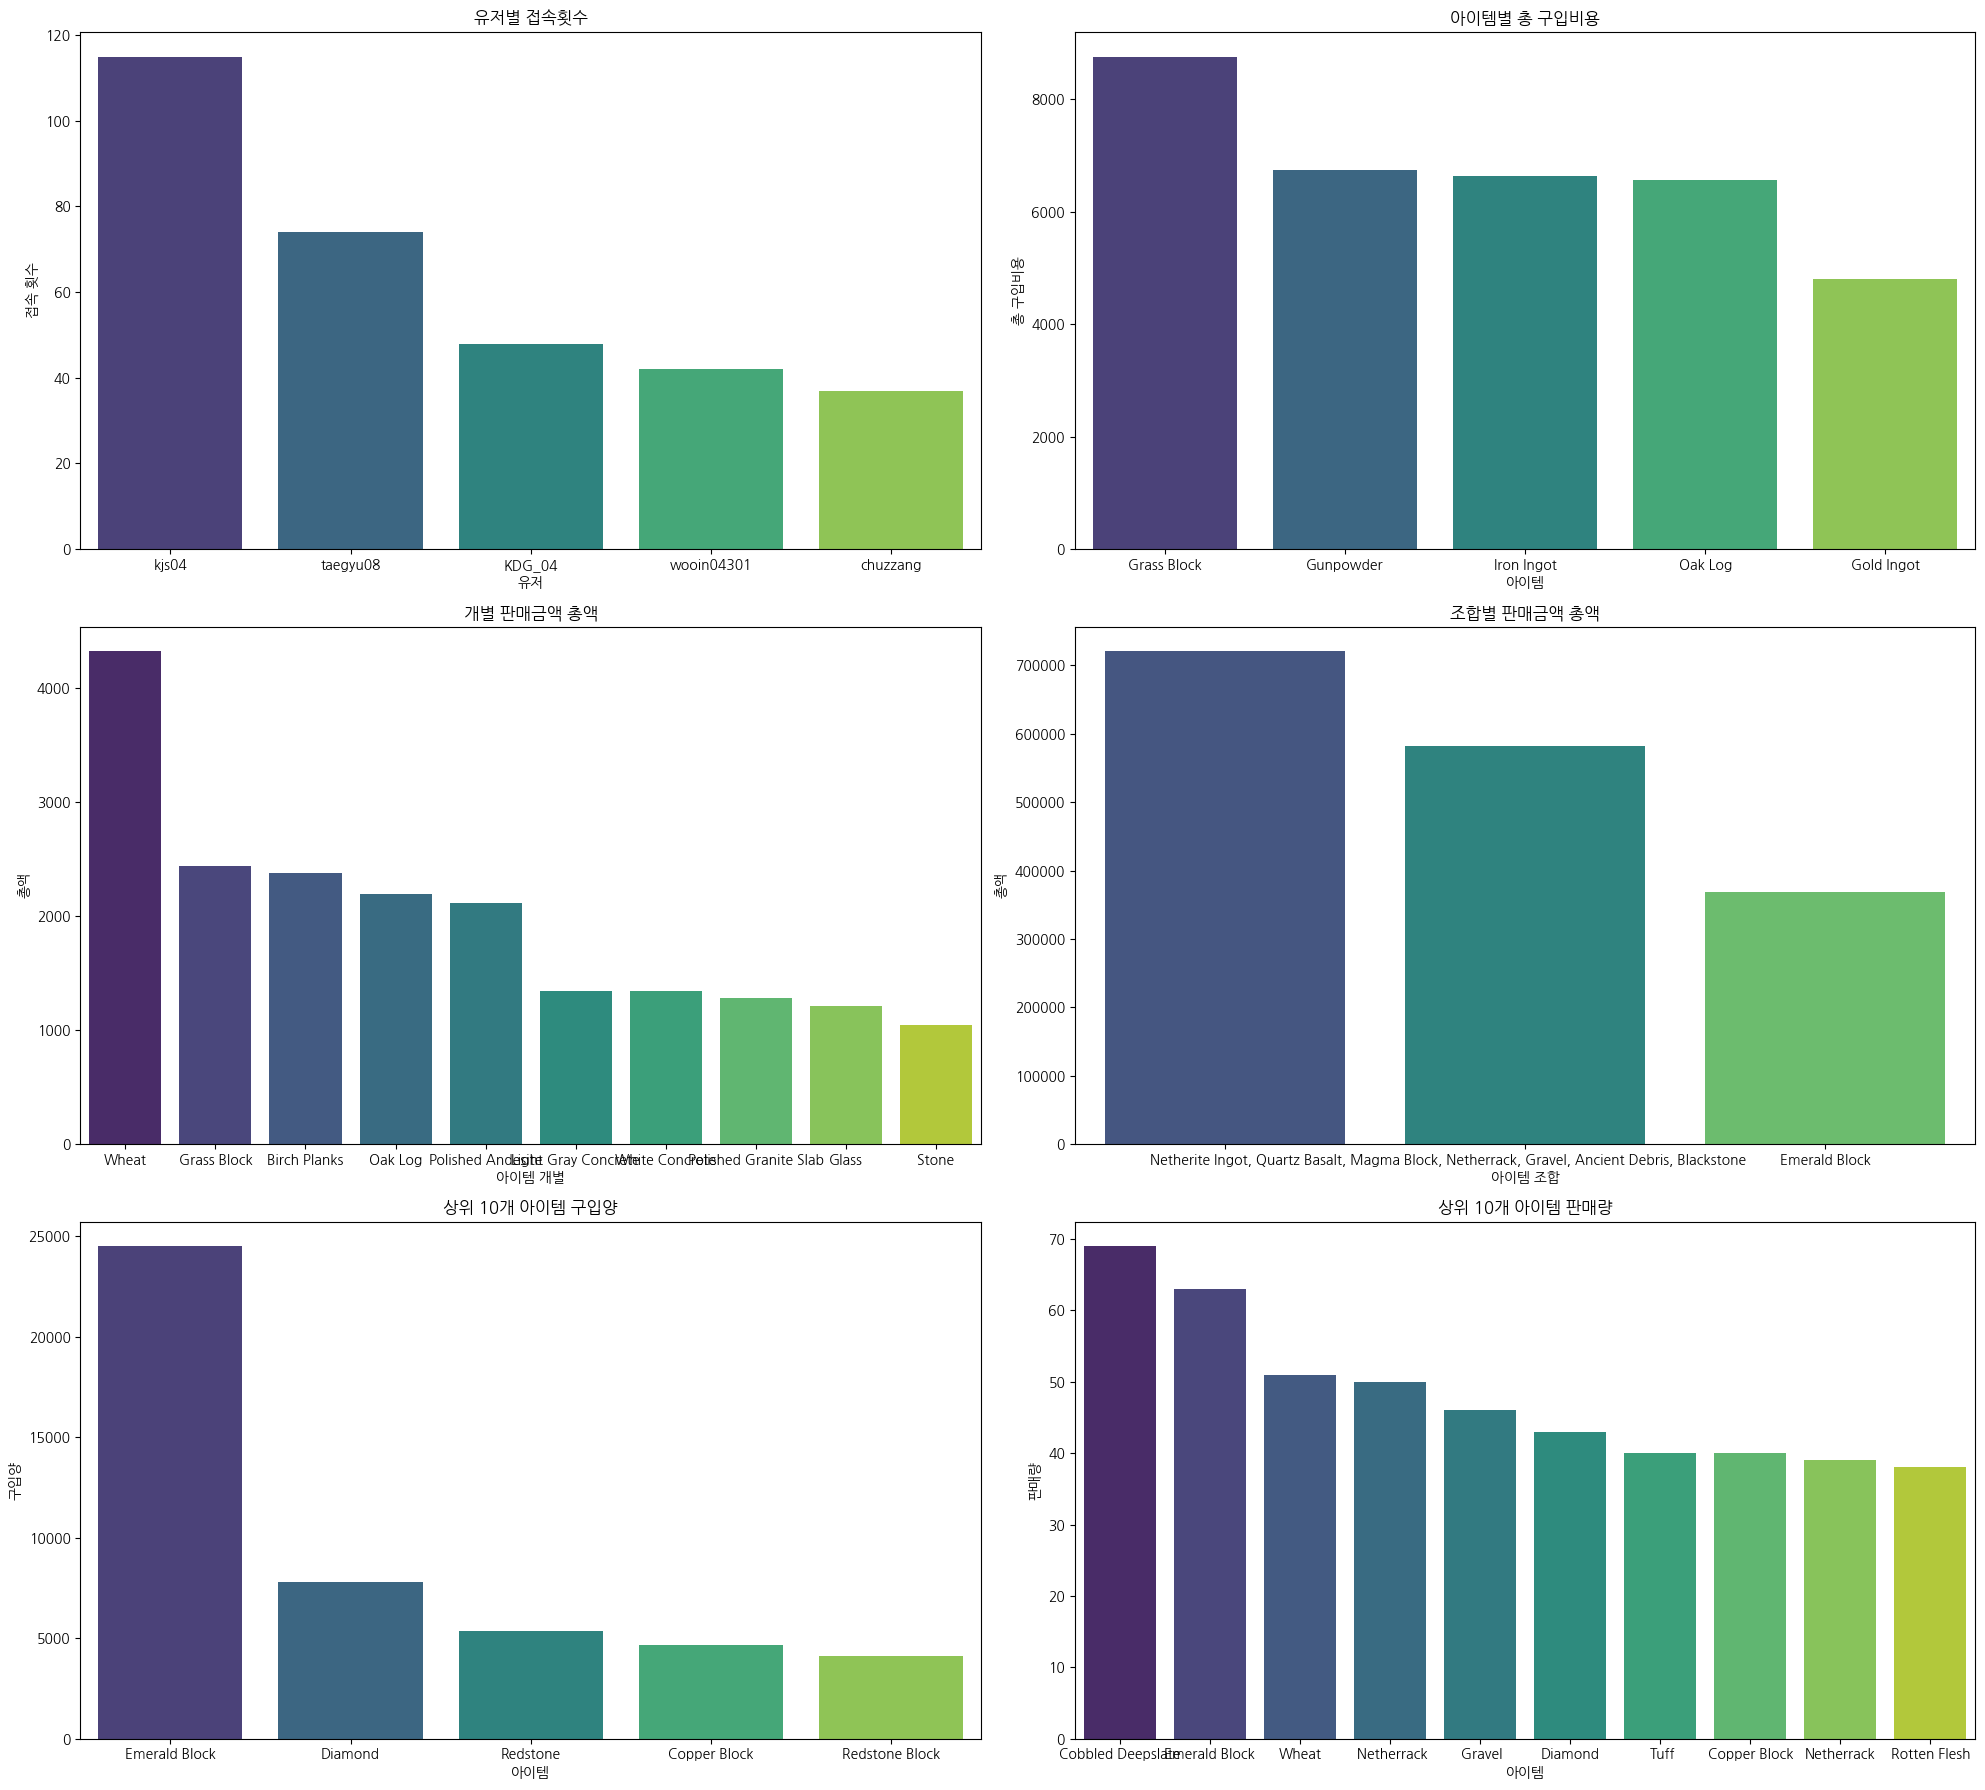

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# 첫 번째 그래프: 유저별 접속횟수
sns.barplot(x=top_users.index, y=top_users.values, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_xlabel('유저')
axes[0, 0].set_ylabel('접속 횟수')
axes[0, 0].set_title('유저별 접속횟수')

# 두 번째 그래프: 아이템별 총 구입비용
sns.barplot(x=top_item_cost.index, y=top_item_cost.values, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_xlabel('아이템')
axes[0, 1].set_ylabel('총 구입비용')
axes[0, 1].set_title('아이템별 총 구입비용')

# 세 번째 그래프: 개별 판매금액 총액
sns.barplot(x=top_item_sell_total2.index, y=top_item_sell_total2.values, ax=axes[2, 0], palette='viridis')
axes[1, 0].set_xlabel('아이템 개별')
axes[1, 0].set_ylabel('총액')
axes[1, 0].set_title('개별 판매금액 총액')


# 네 번째 그래프: 조합별 판매금액 총액
sns.barplot(x=top_item_sell_total.index, y=top_item_sell_total.values, ax=axes[1, 1], palette='viridis')
axes[1, 1].set_xlabel('아이템 조합')
axes[1, 1].set_ylabel('총액')
axes[1, 1].set_title('조합별 판매금액 총액')


# 다섯 번째 그래프: 아이템별 총 구입양
sns.barplot(x=top_item_count.index, y=top_item_count.values, ax=axes[1, 0], palette='viridis')
axes[2, 0].set_xlabel('아이템')
axes[2, 0].set_ylabel('구입양')
axes[2, 0].set_title('상위 10개 아이템 구입양')


# 여섯 번째 그래프: 상위 10개 품목 판매량
sns.barplot(x='아이템', y='판매량', data=sell_count_data, ax=axes[2, 1], palette='viridis')  
axes[2, 1].set_xlabel('아이템')
axes[2, 1].set_ylabel('판매량')
axes[2, 1].set_title('상위 10개 아이템 판매량')

# sns.barplot(x=top_item_category.index, y=top_item_category.values, ax=axes[2], palette='viridis')
# axes[2].set_xlabel('아이템')
# axes[2].set_ylabel('총 구입양')

# 그래프 간 간격 조정
plt.tight_layout()
plt.show()